# Instalando bibliotecas

In [ ]:
!pip install -U image-classifiers==1.0.*
!pip install -U efficientnet==1.0.*
!pip install -U segmentation-models

# Incluido as máscaras e imagens no ambiente atual

In [ ]:
!unzip "/content/gdrive/MyDrive/Projeto Odonto/Images-02.zip"
!unzip "/content/gdrive/MyDrive/Projeto Odonto/Masks-02.zip"

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importando bibliotecas

In [2]:
import matplotlib.pyplot as plt
from skimage import io, transform, util
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import random
import datetime
import math
import glob
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


# Declarando uma classe Dataset de apoio

In [ ]:
class Dataset(tf.keras.utils.Sequence):
  def __init__(self, x_set, y_set, batch_size, size:tuple=(512,512)):
    self.x, self.y = x_set, y_set
    random.shuffle(self.x)
    self.batch_size = batch_size
    self.size = size

  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
		#batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

    imgs = []
    masks = []

    for filename_img in batch_x:
      img = io.imread(filename_img, as_gray=True)
			#cropped_imgs = crop_img_into_imgs(img, self.size)
      imgs.append(transform.resize(img, self.size))

      masks_ = []
			#masks_ = [ [] for _ in range(len(cropped_imgs)) ]
      mask_path = filename_img.split('/')[-1].split('.')[0]
      mask_path = glob.glob(os.path.join(self.y, mask_path, '*'))

      for filename_mask in mask_path:
        mask = io.imread(filename_mask, as_gray=True)
        masks_.append(transform.resize(mask, self.size))
				#cropped_masks = crop_img_into_imgs(mask, self.size)

				#for i, cropped_mask in enumerate(cropped_masks):
				#	masks_[i].append(cropped_mask)
				
			#masks_ = [ np.array(mask).swapaxes(0, -1) for mask in masks_ ]
      masks_ = np.array(masks_).swapaxes(0, -1)

			#imgs.extend(cropped_imgs)
			#masks.extend(masks_)
      masks.append(masks_)
		
    imgs = np.array(imgs)
    imgs = np.expand_dims(imgs, -1)
		#print(imgs.shape)
    masks = np.array(masks)

    return imgs, masks

  def split(self, split_rate):
    splitted_x = self.x[:math.ceil(split_rate * len(self.x))]
    self.x = self.x[math.ceil(split_rate * len(self.x)):]

    return Dataset(splitted_x, self.y, math.ceil(split_rate * self.batch_size), self.size)

# Pré-processamento das imagens

## Métodos de apoio para a obtencao das imagens e mascaras no tamanho correto

In [3]:
def pad_img(img:np.ndarray, size:tuple):
	img_padded = np.pad(img, ( (0, size[0] - img.shape[0]), (0, size[1] - img.shape[1])), 'constant', constant_values=(0))
	return img_padded

def crop_img_into_imgs(img:np.ndarray, size:tuple) -> list:
	mult_x = img.shape[0] / size[0]
	mult_y = img.shape[1] / size[1]
	
	img_padded = pad_img(img, (size[0] * math.ceil(mult_x), size[1] * math.ceil(mult_y)))

	imgs = []

	for i in range(math.ceil(mult_x)):
		for j in range(math.ceil(mult_y)):
			imgs.append(img_padded[(i * size[0]):((i + 1) * size[0]), (j * size[1]):((j + 1) * size[1])])
		
	return imgs

## Carregando as imagens e máscaras

In [4]:
def load_img_and_masks(img_location, masks_location, size=(512,512), multiple_masks=True):
  id = img_location.split('/')[-1].split('.')[0]
  masks_location = glob.glob(os.path.join(masks_location, id, '*'))
  masks = []

  img = io.imread(img_location, as_gray=True)
  img = transform.resize(img, size)
	#imgs = crop_img_into_imgs(img, size)
	#masks = [ [] for _ in range(len(imgs)) ]

  for mask_location in masks_location:
    mask = io.imread(mask_location, as_gray=True)
    masks.append(transform.resize(mask, size))
		#cropped_masks = crop_img_into_imgs(mask, size)

		#for i, cropped_mask in enumerate(cropped_masks):
		#	masks[i].append(cropped_mask)
			
	# tranforma uma lista de mascaras em uma mascara com o numero de canais igual a quantidade de mascaras
	#print(np.array(masks).shape)
	#print(np.ndarray(masks).shape)
	#masks = [ np.array(mask).swapaxes(0, -1) for mask in masks ]
  masks = np.array(masks).swapaxes(0, -1)
		
  return img, masks

def load_data(imgs_path:list, masks_path:str, size:tuple):
	imgs_path = imgs_path
	imgs = []
	masks = []

	for img_path in imgs_path:
		x, y = load_img_and_masks(img_path, masks_path, size)
		imgs.append(x)
		masks.append(y)

	return imgs, masks

def preprocess_data(imgs, masks):
  imgs = np.array(imgs)
  imgs = np.expand_dims(imgs, -1)

  masks = np.array(masks)

  return imgs, masks

## Aumento de dados


In [ ]:
def rotate_img_mask(img:np.ndarray, masks:np.ndarray, angle:float):
	rotated_img = transform.rotate(img, angle)
	rotated_masks = transform.rotate(masks, angle)

	return rotated_img, rotated_masks

def rotate_imgs_masks(imgs:list, masks:list, angle:float):
	rotated_imgs = []
	rotated_masks = []

	for i, img in enumerate(imgs):
		rotated_img, rotated_mask = rotate_img_mask(img, masks[i], angle)
		rotated_imgs.append(rotated_img)
		rotated_masks.append(rotated_mask)

	return rotated_imgs, rotated_masks

def fliplr_img_mask(img:np.ndarray, mask:np.ndarray) -> tuple:
	flipped_img = np.fliplr(img)
	flipped_mask = np.fliplr(mask)
	
	return flipped_img, flipped_mask

def fliplr_imgs_masks(imgs:list, masks:list) -> tuple:
	flipped_imgs = []
	flipped_masks = []
	for img, mask in zip(imgs, masks):
		flipped_img, flipped_masks_ = fliplr_img_mask(img, mask)
		flipped_imgs.append(flipped_img)
		flipped_masks.append(flipped_masks_)

	return flipped_imgs, flipped_masks

def random_noise_imgs_masks(imgs:list, masks:list, mode='gaussian') -> tuple:
	noised_imgs = []
	for img in imgs:
		noised_imgs.append(util.random_noise(img, mode))

	return noised_imgs, masks

# Definindo o modelo, compilando e treinando

In [33]:
sm.set_framework('tf.keras')

model = sm.Unet(classes=6, activation='sigmoid', input_shape=(None, None, 1), encoder_weights=None)

model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

horario = datetime.datetime.now()

callbacks = [ tf.keras.callbacks.ModelCheckpoint(f'./Backups/Models/{horario.isoformat()}.hdf5', save_best_only=True),
              tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', patience=4),
              tf.keras.callbacks.TensorBoard(log_dir='./log', write_images=True) ]

imgs_path = random.sample(glob.glob('/content/Images-02/*'), 151)
masks_path = '/content/Masks-02/'

In [34]:
imgs, masks = load_data(imgs_path, masks_path, (512,512))
print(len(imgs))
print(len(masks))

In [35]:
x, y = preprocess_data(imgs, masks)
print(x.shape)
print(y.shape)

(151, 512, 512, 1)
(151, 512, 512, 6)


In [ ]:
model.fit(x, y, batch_size=5, epochs=10, validation_split=0.2, callbacks=callbacks)

Epoch 1/10
24/24 [==============================] - 1699s 71s/step - loss: 1.2706 - iou_score: 4.3377e-05 - val_loss: 1.0108 - val_iou_score: 1.1813e-05
Epoch 2/10
24/24 [==============================] - 1689s 71s/step - loss: 1.0669 - iou_score: 4.2904e-05 - val_loss: 1.0551 - val_iou_score: 3.3517e-05
Epoch 3/10
24/24 [==============================] - 1695s 71s/step - loss: 1.0277 - iou_score: 4.2456e-05 - val_loss: 1.0872 - val_iou_score: 4.1306e-05
Epoch 4/10
24/24 [==============================] - 1690s 71s/step - loss: 1.0162 - iou_score: 4.2357e-05 - val_loss: 1.0712 - val_iou_score: 4.3858e-05
Epoch 5/10
24/24 [==============================] - 1693s 71s/step - loss: 1.0111 - iou_score: 4.2048e-05 - val_loss: 1.0344 - val_iou_score: 4.1846e-05
Epoch 6/10
24/24 [==============================] - 1808s 76s/step - loss: 1.0083 - iou_score: 4.1684e-05 - val_loss: 1.0176 - val_iou_score: 4.0987e-05
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 1.0064 - iou_s

# Verificando o modelo treinado

In [24]:
predict_img = io.imread('/content/imagem-001.jpg', as_gray=True)
predict_img = transform.resize(predict_img, (512,512))
predict_img = np.expand_dims(predict_img, 2)
predict_img = np.expand_dims(predict_img, 0)
print(predict_img.shape)

predicted_mask = model.predict(predict_img)

(1, 512, 512, 1)


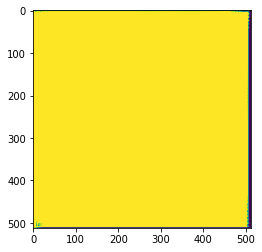

In [31]:
plt.imshow(predicted_mask[0,:,:,5])

# Salvando o modelo

In [ ]:
model.save('model1.hdf5')